In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from imutils import paths
import skimage.measure
from google.colab.patches import cv2_imshow

In [ ]:
import tensorflow as tf
def PSNR(y_true,y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=255)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data_dir, mode='fit', batch_size=8,dim=(256, 256),scale=0.5, channels=3, shuffle=True):
        self.list_image = list(paths.list_images(data_dir))
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.scale=scale
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
   
    # phương thức này sẽ được tự đông gọi khi kết thúc 1 epoch, để đảo ngẫu nhiên lại thứ tự các ảnh khi train
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # trả về số lượng batch
    def __len__(self):
        return int(np.floor(len(self.list_image) / self.batch_size))
    
    # trả về batch tương ứng với index
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        if self.mode == 'fit':
            # các train data của batch đó sẽ được lưu vào biến X
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            # nếu model đang train thì cần tạo thêm dữ liệu về ảnh gốc của batch đó
            y = np.empty((self.batch_size, *self.dim, self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                y[i]=img

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img

            return X,y
                
                
        # nếu model đang predict thì không cần tạo thêm dữ liệu về ảnh gốc của batch đó
        elif self.mode == 'predict':
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            

In [ ]:
train_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Train')
val_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Valid')

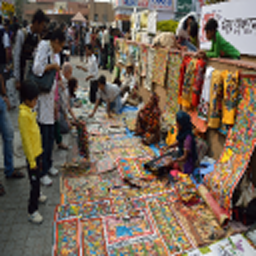

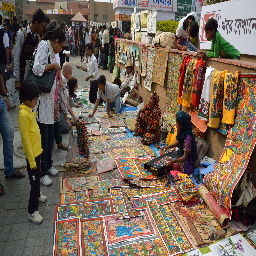

In [ ]:
#lấy thử cuối cùng của batch thứ 10 xem thử
img_lr= train_data_generator[10][0][-1]
img_hr=train_data_generator[10][1][-1]
cv2_imshow(img_lr)
cv2_imshow(img_hr)

In [ ]:
def SRCNN(height=256, width=256, channels=3, load_weights=False, batch_size=128):
  X_input = Input(shape=(height,width,channels))
  X = Conv2D(64, (9,9), activation = 'relu', padding = 'same')(X_input)
  X = BatchNormalization(axis = 3)(X)
  X = Conv2D(32, (1,1), activation = 'relu', padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  out = Conv2D(3,(5,5), activation = 'relu', padding = 'same')(X)
  model = Model(inputs = X_input, outputs = out, name = 'SRCNN')
  return model

In [ ]:
def resnet_lite(height=256, width=256, channels=3, load_weights=False, batch_size=128):
  X_input = Input(shape=(height,width,channels))
  X0 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(X_input)
  x = Conv2D(32, (3,3), activation = 'linear', padding = 'same')(X0)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3,3), activation = 'linear', padding = 'same')(x)
  x = BatchNormalization(axis = 3)(x)
  x = Add()([x,X0])
  x = Add()([x,X0])
  x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
  out = Conv2D(3, (3,3), activation = 'linear', padding = 'same')(x)
  model = Model(inputs = X_input, outputs = out, name = 'resnetSR')
  return model

In [ ]:
def residual_block(ip, id):
    init = ip

    x = Conv2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_1')(ip)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_1")(x, training=True)
    x = Activation('relu', name="sr_res_activation_" + str(id) + "_1")(x)

    x = Conv2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_2')(x)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_2")(x, training=True)

    m = Add(name="sr_res_merge_" + str(id))([x, init])

    return m

def resnetSR(height=256, width=256, channels=3, load_weights=False, batch_size=128):
    init= Input(shape=(height,width,channels))

    x0 = Conv2D(64, (3, 3), activation='relu', padding='same', name='sr_res_conv1')(init)

    x = residual_block(x0, 1)

    nb_residual = 5
    for i in range(nb_residual):
        x = residual_block(x, i + 2)

    x = Add()([x, x0])
    x = Conv2D(3, (3, 3), activation="linear", padding='same', name='sr_res_conv_final')(x)

    model = Model(init, x)
    return model


In [ ]:
def Auto_Encoder(height=256, width=256, channels=3, load_weights=False, batch_size=128):
  X_input = Input(shape=(height,width,channels))  
  #encoding architecture
  x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(X_input)
  x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
  x3 = MaxPooling2D(padding='same')(x2)
  x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
  x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
  x6 = MaxPooling2D(padding='same')(x5)
  encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
  # decoding architecture
  x7 = Conv2DTranspose(256, (3,3), padding = 'same', strides = (2,2), kernel_initializer='he_uniform', activation='relu', activity_regularizer = regularizers.l1(10e-10))(encoded)
  x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
  x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
  x10 = Add()([x5, x9])
  x11 = Conv2DTranspose(128, (3,3), padding = 'same', strides = (2,2), kernel_initializer='he_uniform', activation='relu', activity_regularizer = regularizers.l1(10e-10))(x10)
  x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
  x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
  x14 = Add()([x2, x13])
  decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
  model = Model(inputs = X_input, outputs = decoded, name = 'AESR')
  return model


In [ ]:
auto_encoder = load_model('/content/drive/Shareddrives/PMAT/Final/weights/AE.h5')
resnet = load_model('/content/drive/Shareddrives/PMAT/Final/weights/resnet.h5')
srcnn = load_model('/content/drive/Shareddrives/PMAT/Final/weights/srcnn_tuan.h5')
resnet_l = load_model('/content/drive/Shareddrives/PMAT/Final/weights/resnetSR(lite).h5')

In [ ]:
auto_encoder.compile(loss='mse',metrics=[PSNR])
auto_encoder.evaluate(val_data_generator)

12/12 [==============================] - 24s 859ms/step - loss: 382.0012 - PSNR: 23.4283


[382.001220703125, 23.428335189819336]

In [ ]:
resnet.compile(loss='mse',metrics=[PSNR])
resnet.evaluate(val_data_generator)

12/12 [==============================] - 12s 915ms/step - loss: 396.3909 - PSNR: 23.3171


[396.390869140625, 23.317100524902344]

In [ ]:
resnet_l.compile(loss='mse',metrics=[PSNR])
resnet_l.evaluate(val_data_generator)

12/12 [==============================] - 11s 804ms/step - loss: 397.9567 - PSNR: 23.1751


[397.9566955566406, 23.175079345703125]

In [ ]:
srcnn.compile(loss='mse',metrics=[PSNR])
srcnn.evaluate(val_data_generator)

12/12 [==============================] - 10s 773ms/step - loss: 581.2148 - PSNR: 21.2076


[581.2147827148438, 21.2076473236084]

In [ ]:
%cd /content/drive/Shareddrives/PMAT/Image_demo

/content/drive/Shareddrives/PMAT/Image_demo


In [ ]:
!ls

0829.png  0829x8.png  0850.png	0850x8.png  0855.png  0855x8.png


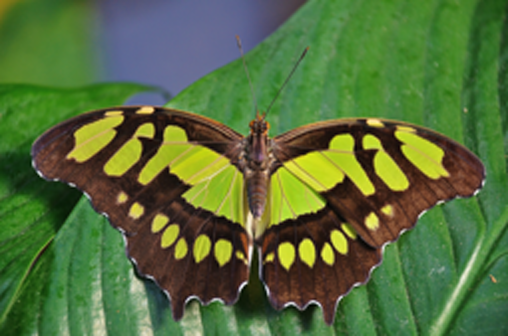

In [ ]:
import math
hr = cv2.imread('0829.png')
lr = cv2.imread('0829x8.png')
h = math.floor((lr.shape[1]*2)/4)*4
w = math.floor((lr.shape[0]*2)/4)*4
img= cv2.resize(lr, (h,w),interpolation=cv2.INTER_CUBIC )
cv2_imshow(img)

In [ ]:
img.shape

(336, 508, 3)

In [ ]:
model_AE = Auto_Encoder(img.shape[0], img.shape[1])
model_AE.load_weights('/content/drive/Shareddrives/PMAT/weights/AE.h5')
model_resnet = resnetSR(img.shape[0], img.shape[1])
model_resnet.load_weights('/content/drive/Shareddrives/PMAT/weights/resnet.h5')
model_resnet_lite = resnet_lite(img.shape[0], img.shape[1])
model_resnet_lite.load_weights('/content/drive/Shareddrives/PMAT/weights/resnetSR(lite).h5')
model_srcnn = SRCNN(img.shape[0], img.shape[1])
model_srcnn.load_weights('/content/drive/Shareddrives/PMAT/weights/srcnn_tuan.h5')

In [ ]:
model_AE.summary()

Model: "AESR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 336, 508, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 336, 508, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 336, 508, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

In [ ]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 336, 508, 3  0           []                               
                                )]                                                                
                                                                                                  
 sr_res_conv1 (Conv2D)          (None, 336, 508, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sr_res_conv_1_1 (Conv2D)       (None, 336, 508, 64  36928       ['sr_res_conv1[0][0]']           
                                )                                                             

In [ ]:
model_resnet_lite.summary()

Model: "resnetSR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 336, 508, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 336, 508, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 336, 508, 32  9248        ['conv2d_10[0][0]']              
                                )                                                          

In [ ]:
model_srcnn.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 336, 508, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 336, 508, 64)      15616     
                                                                 
 batch_normalization_2 (Batc  (None, 336, 508, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (None, 336, 508, 32)      2080      
                                                                 
 batch_normalization_3 (Batc  (None, 336, 508, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (None, 336, 508, 3)       2403  

In [ ]:
img_ = img.reshape(1,*img.shape)

In [ ]:
from datetime import datetime

Autoencoder time: 0:00:02.352550


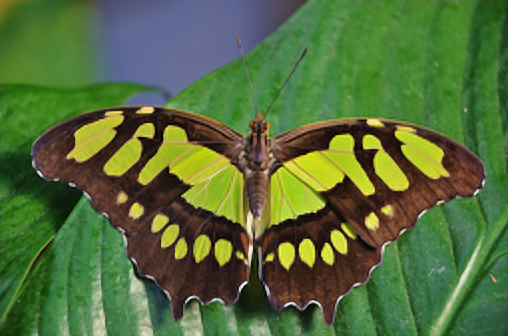

In [ ]:
start=datetime.now()
img_AE= model_AE.predict(img_)[0]
print(f"Autoencoder time: {datetime.now()-start}")
cv2_imshow(img_AE)

ResNet time: 0:00:00.352079


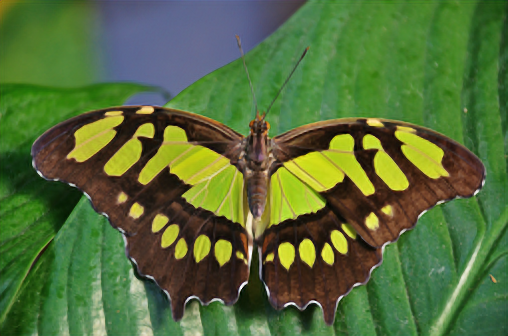

In [ ]:
start=datetime.now()
img_resnet= model_resnet.predict(img_)[0]
print(f"ResNet time: {datetime.now()-start}")
cv2_imshow(img_resnet)

ResNet lite time: 0:00:00.193009


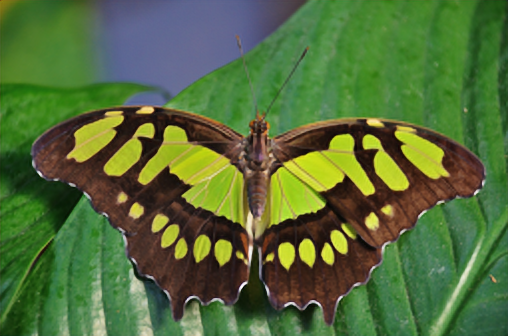

In [ ]:
start=datetime.now()
img_resnet_lite= model_resnet_lite.predict(img_)[0]
print(f"ResNet lite time: {datetime.now()-start}")
cv2_imshow(img_resnet_lite)

SRCNN time: 0:00:00.155355


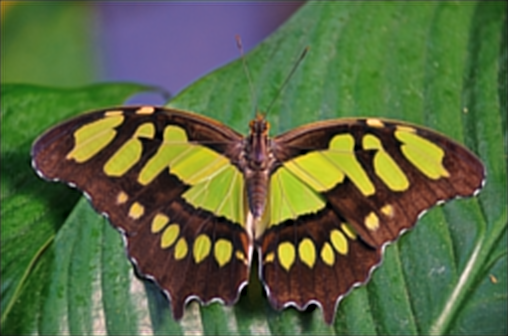

In [ ]:
start=datetime.now()
img_srcnn= model_srcnn.predict(img_)[0]
print(f"SRCNN time: {datetime.now()-start}")
cv2_imshow(img_srcnn)